## Translating Wikidata queries to DBpedia with LLMs

In [3]:
# import all the necessary libraries
import re
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
from openai import OpenAI

Create dataset for asking the LLMs

In [2]:
# Load the dataset from 100_complete_entries.json
with open("../../../data/100_complete_entries_wikidata.json", "r") as file:
    data = json.load(file)

# Create input dataset for the LLM
llm_inputs = []

for entry in data:
    # Extract required fields
    question = entry.get("question", "")  # Natural language question
    wikidata_query = entry.get("wikidata_query", "")  # SPARQL query for wikidata
    
    # Extract entities and relations (ER2) in dbpedia
    er2 = [
        {
            "dbpedia_id": er["dbpedia_id"],
            "wikidata_ids": er["wikidata_ids"]
        }
        for er in entry.get("mapped_entities_relations", {}).get("entities_relations", [])
        if er["dbpedia_id"]  # Only include non-empty dbpedia mappings
    ]
    
    # Skip if there are no valid Wikidata mappings
    if not er2:
        continue

    # Construct the input for the LLM
    llm_input = {
        "context": {
            "natural_language_question": question,
            "sparql_query_kg1": wikidata_query,
            "kg1_name": "Wikidata",
            "kg2_name": "DBpedia",
            "er2": er2,
            "instruction": "Given the information above, produce a SPARQL query for KG2. In your answer please hightlight the final, complete SPARQL query within the tags '<sparql>' and '</sparql>'."
        }
    }
    llm_inputs.append(llm_input)

# Save the processed dataset to a new JSON file
with open("llm_input_dataset_wikidata.json", "w") as file:
    json.dump(llm_inputs, file, indent=4)

print(f"Processed dataset saved to 'llm_input_dataset_wikidata.json'.")

Processed dataset saved to 'llm_input_dataset_wikidata.json'.


## Testing meta-llama-3.1-8b-instruct with 100 queries
The model includes 8billion parameters and is one of the samallest available models at Academic Cloud.

In [3]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct"  # Replace with the appropriate model

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset_wikidata.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_meta-llama-3.1-8b_wikidata.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b_wikidata.json'.")


Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b_wikidata.json'.


## Testing Mistral-Large-instruct with 100 queries
The model includes 123billion parameters and is the largest available model at Academic Cloud https://chat-ai.academiccloud.de

In [4]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "mistral-large-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset_wikidata.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_mistral_wikidata.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral_wikidata.json'.")

Error querying LLM for question ID What is the largest country in the world?: Error code: 429 - {'message': 'API rate limit exceeded', 'request_id': '17613443113cec7782b0bd1e83410d20'}
Error querying LLM for question ID What is the alma mater of the chancellor of Germany Angela Merkel?: Error code: 429 - {'message': 'API rate limit exceeded', 'request_id': 'b780881bd6bb653167e166671d872712'}
Error querying LLM for question ID Who created Goofy?: Error code: 429 - {'message': 'API rate limit exceeded', 'request_id': 'c43f9d7bca4cc42b73337628a93f674a'}
Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral_wikidata.json'.


## Analysis of the results
Extracting the SPARQL queries from LLM output for **mistral-large-instruct**.

In [14]:
# Load the input JSON file
file_path = "translated_llm_output_mistral_wikidata.json"
with open(file_path, "r") as file:
    data = json.load(file)

# Function to extract SPARQL query from the `sparql_query_kg2` field and remove comments
def extract_sparql_query(entry):
    raw_query = entry.get("sparql_query_kg2", "")
    # Remove comments starting with `#` and clean up spaces
    cleaned_query = re.sub(r"#.*", "", raw_query)  # Remove everything after `#` on each line
    # Extract content between SPARQL code blocks (```sparql and ``` or similar markers)
    match = re.search(r"```sparql\n(.*?)\n```", cleaned_query, re.DOTALL)
    if match:
        return match.group(1).replace("\n", " ").strip()  # Remove newline characters and trim whitespace
    return None

# Initialize counts and results tracking
queries_with_context = []
failed_queries = []
total_entries = len(data)
extracted_count = 0

# Extract SPARQL queries
for entry in data:
    sparql_query = extract_sparql_query(entry)
    if sparql_query:
        queries_with_context.append({
            "natural_language_question": entry["context"]["natural_language_question"],
            "sparql_query_kg2": sparql_query
        })
        extracted_count += 1
    else:
        failed_queries.append({
            "natural_language_question": entry["context"]["natural_language_question"],
            "sparql_query_raw": entry.get("sparql_query_kg2", "")
        })

# Save the extracted queries to a new JSON file
output_file = "mistral_wiki_trans_sparql_queries.json"
with open(output_file, "w") as file:
    json.dump(queries_with_context, file, indent=4)

# Save the failed extractions to a separate file
failed_output_file = "failed_mistral_wiki_sparql_queries.json"
with open(failed_output_file, "w") as file:
    json.dump(failed_queries, file, indent=4)

# Print statistics
failed_count = total_entries - extracted_count
success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0

print(f"Cleaned and extracted data has been saved to {output_file}.")
print(f"Failed extractions saved to {failed_output_file}.")
print(f"Total entries processed: {total_entries}")
print(f"Successfully extracted queries: {extracted_count}")
print(f"Failed queries: {failed_count}")
print(f"Extraction success rate: {success_rate:.2f}%")


Cleaned and extracted data has been saved to mistral_wiki_trans_sparql_queries.json.
Failed extractions saved to failed_mistral_wiki_sparql_queries.json.
Total entries processed: 97
Successfully extracted queries: 95
Failed queries: 2
Extraction success rate: 97.94%


Extracting the SPARQL queries from LLM output for **lama-3.1-8b-instruct**.

In [25]:
input_file_path = 'translated_llm_output_meta-llama-3.1-8b_wikidata.json'
output_file_path = 'lama_wiki_trans_sparql_queries.json'
failed_output_file_path = 'failed_lama_wiki_sparql_queries.json'

# Load the JSON file
with open(input_file_path, 'r') as file:
    data = json.load(file)

# Function to extract and clean SPARQL queries
def extract_and_clean_sparql_query(sparql_raw):
    try:
        # Try to match SPARQL queries enclosed in <sparql>...</sparql> tags first
        sparql_match = re.search(r"<sparql>(.*?)</sparql>", sparql_raw, re.DOTALL)
        if not sparql_match:
            # Fallback to matching code blocks or queries starting with PREFIX
            sparql_match = re.search(r"```sparql\s*(.*?)\s*```|PREFIX.*?WHERE\s*\{.*?\}", sparql_raw, re.DOTALL)

        if sparql_match:
            # Extract the matched SPARQL query (first non-None match)
            query = sparql_match.group(1) or sparql_match.group(0)
            # Clean query by removing comments and excessive whitespace
            query = re.sub(r"#.*", "", query)  # Remove comments
            query = re.sub(r"\s+", " ", query).strip()  # Remove excessive whitespace and newlines
            query = query.replace("```sparql", "").replace("```", "").replace("<sparql>", "").replace("</sparql>", "").strip()
            return query
    except Exception as e:
        print(f"Error cleaning SPARQL query: {e}")
    return None

# Initialize results tracking
result = []
failed_queries = []
total_entries = len(data)
extracted_count = 0

# Process all entries and keep natural language question with the query
for entry in data:
    context = entry.get('context', {})
    natural_language_question = context.get('natural_language_question', None)
    sparql_query_raw = entry.get('sparql_query_kg2', '')

    # Extract and clean the SPARQL query
    sparql_query = extract_and_clean_sparql_query(sparql_query_raw)

    if natural_language_question and sparql_query:
        result.append({
            "natural_language_question": natural_language_question,
            "sparql_query": sparql_query
        })
        extracted_count += 1
    else:
        failed_queries.append({
            "natural_language_question": natural_language_question,
            "sparql_query_raw": sparql_query_raw
        })

# Save the successfully extracted queries to a new JSON file
with open(output_file_path, 'w') as output_file:
    json.dump(result, output_file, indent=4)

# Save the failed extractions for debugging
with open(failed_output_file_path, 'w') as failed_file:
    json.dump(failed_queries, failed_file, indent=4)

# Print statistics
failed_count = total_entries - extracted_count
success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0

print(f"Cleaned and extracted data has been saved to {output_file_path}.")
print(f"Failed extractions saved to {failed_output_file_path}.")
print(f"Total entries processed: {total_entries}")
print(f"Successfully extracted queries: {extracted_count}")
print(f"Failed queries: {failed_count}")
print(f"Extraction success rate: {success_rate:.2f}%")


Cleaned and extracted data has been saved to lama_wiki_trans_sparql_queries.json.
Failed extractions saved to failed_lama_wiki_sparql_queries.json.
Total entries processed: 100
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%


## Run the extracted SPARQL queries on Wikidata
Results for **mistral-large-instruct**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Prefix rdf was not registered using a PREFIX declaration",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 133,\n        "query": "PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX dbp: <http://dbpedia.org/property/> SELECT DISTINCT ?uri ?elevation WHERE {   ?uri rdf:type dbo:Mountain ;        dbo:elevation ?elevation . } ORDER BY DESC(?elevation) LIMIT 1",\n        "startIndex": 133,\n        "stopIndex": 140\n    },\n    "query": "PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX dbp: <http://dbpedia.org/property/> SELECT DISTINCT ?uri ?elevation WHERE {   ?uri rdf:type dbo:Mountain ;        dbo:elevation ?elevation . } ORDER BY DESC(?elevation) LIMIT 1",\n    "resultsize": 0,\n    "status": "ERROR",\n    "time": {\n        "computeResult": 1,\n        "total": 1\n    }\n}'
Query failed: QueryB

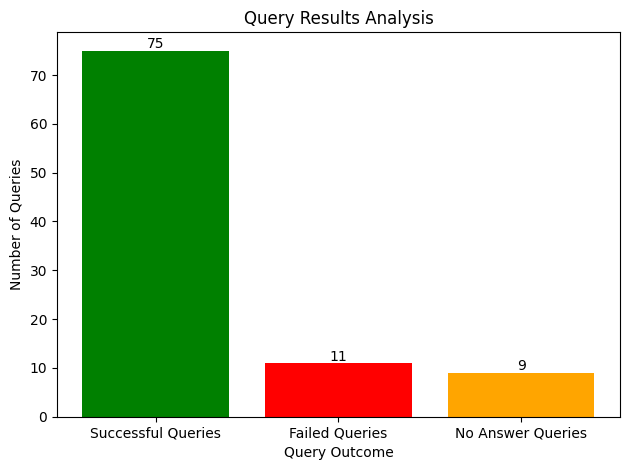

In [27]:
# File paths
input_file_path = "mistral_wiki_trans_sparql_queries.json"
output_file_path = "dbpedia_query_results_mistral.json"

# Wikidata local endpoint
DBpedia_ENDPOINT = "http://localhost:7012"

# Define prefixes for the queries
PREFIXES = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX res: <http://dbpedia.org/resource/>
PREFIX yago: <http://dbpedia.org/class/yago/>
PREFIX onto: <http://dbpedia.org/ontology/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX dbc: <http://dbpedia.org/resource/Category:>
PREFIX dct: <http://purl.org/dc/terms/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()  # Return results
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Append the value directly
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query_kg2", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the DBpedia endpoint
    results = query_sparql(DBpedia_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

Results for **lama-3.1-8b-instruct**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\"Bundesliga\\": mismatched input \'Bundesliga\' expecting \'}\'",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 187,\n        "query": "PREFIX dbpedia-owl: <http://dbpedia.org/ontology/> PREFIX dbpedia: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { ?uri a dbpedia-owl:SoccerClub ; dbpedia-owl:league dbpedia: Bundesliga . }",\n        "startIndex": 187,\n        "stopIndex": 196\n    },\n    "query": "PREFIX dbpedia-owl: <http://dbpedia.org/ontology/> PREFIX dbpedia: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { ?uri a dbpedia-owl:SoccerClub ; dbpedia-owl:league dbpedia: Bundesliga . }",\n    "resultsize": 0,\n    "status": "ERROR",\n    "time": {\n        "computeResult": 0,\n        "total": 0\n    }\n}'
Query failed: QueryBadFormed: A bad request has been se

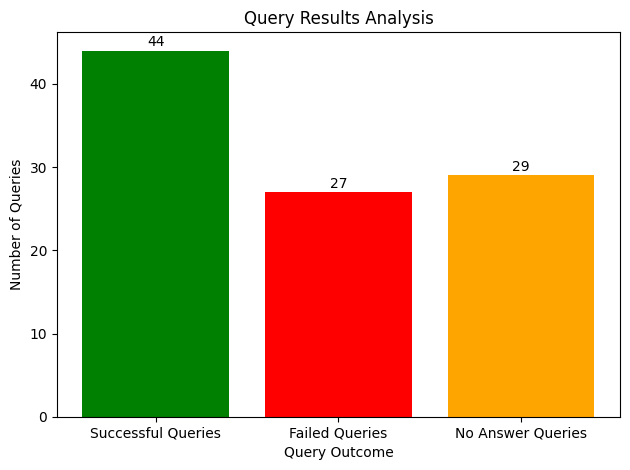

In [28]:
# File paths
input_file_path = "lama_wiki_trans_sparql_queries.json"
output_file_path = "dbpedia_query_results_lama.json"

# Wikidata local endpoint
DBpedia_ENDPOINT = "http://localhost:7012"

# Define prefixes for the queries
PREFIXES = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX res: <http://dbpedia.org/resource/>
PREFIX yago: <http://dbpedia.org/class/yago/>
PREFIX onto: <http://dbpedia.org/ontology/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX dbc: <http://dbpedia.org/resource/Category:>
PREFIX dct: <http://purl.org/dc/terms/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()  # Return results
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Append the value directly
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the DBpedia endpoint
    results = query_sparql(DBpedia_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

## Comparison of DBpedia output with original output
In the following the final output of querying DBpedia is compared to the original output of querying QALD9-Plus dataset.

### Comparison lama-3.1-8b-instruct_template with original output

Comparison completed. Results saved to 'comparison_results_lama_dbpedia.xlsx'.
Total Queries: 100
Correct Queries: 41
Incorrect Queries: 3
Query Failed: 27
No Answer Queries: 29
Accuracy: 41.00%

Comparison with previous step:
Previous Step Total Queries: 100
Previous Step Successful Queries: 100
Previous Step Accuracy: 100.00%


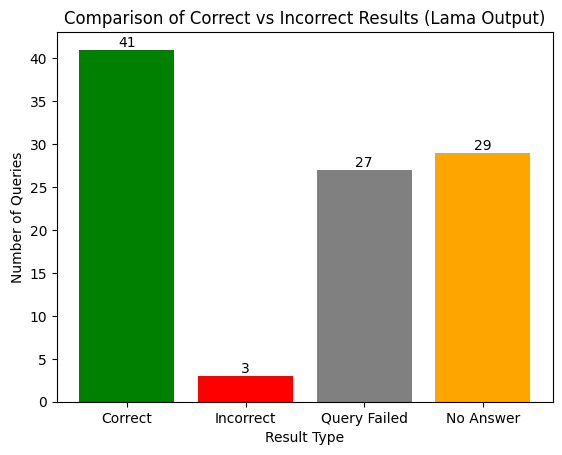

Accuracy improvement from previous step: -59.00%


In [30]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
lama_output_file_path = "dbpedia_query_results_lama.json"
previous_step_output_file_path = "lama_wiki_trans_sparql_queries.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(lama_output_file_path, 'r') as f:
    lama_output_data = json.load(f)

with open(previous_step_output_file_path, 'r') as f:
    previous_step_data = json.load(f)

# Initialize comparison results
comparison_results = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['dbpedia_results'] for entry in solution_data}

# Compare answers
total_questions = len(lama_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0

for lama_entry in lama_output_data:
    question = lama_entry.get("natural_language_question")
    lama_answers = lama_entry.get("answers", [])

    # Skip entries with "Query failed" or "No answer"
    if "Query failed" in lama_answers:
        query_failed_count += 1
        continue
    if "No answer" in lama_answers:
        no_answer_count += 1
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if all expected answers are in the LLM output and vice versa (ignoring order)
        is_correct = set(expected_answers) == set(lama_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "lama_answers": lama_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

# Save the results to an Excel file for review
output_excel_file = "comparison_results_lama_dbpedia.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries: {incorrect_count}")
print(f"Query Failed: {query_failed_count}")
print(f"No Answer Queries: {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")

# Compare with previous step
previous_total_queries = len(previous_step_data)
previous_successful_queries = sum(
    1 for result in previous_step_data if "No answer" not in result["sparql_query"] and "Query failed" not in result["sparql_query"]
)
previous_accuracy = (previous_successful_queries / previous_total_queries) * 100 if previous_total_queries > 0 else 0

print("\nComparison with previous step:")
print(f"Previous Step Total Queries: {previous_total_queries}")
print(f"Previous Step Successful Queries: {previous_successful_queries}")
print(f"Previous Step Accuracy: {previous_accuracy:.2f}%")

# Visualize the current vs previous step comparison
categories = ['Correct', 'Incorrect', 'Query Failed', 'No Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['green', 'red', 'gray', 'orange']

fig, ax = plt.subplots()
bars = ax.bar(categories, counts, color=colors)

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# Configure y-axis to show only integer values
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add title and labels
plt.title('Comparison of Correct vs Incorrect Results (Lama Output)')
plt.xlabel('Result Type')
plt.ylabel('Number of Queries')
plt.show()

# Print final accuracy comparison
print(f"Accuracy improvement from previous step: {accuracy - previous_accuracy:.2f}%")


### Comparison mistral-large-instruct with original output

Comparison completed. Results saved to 'comparison_results_mistral_dbpedia.xlsx'.
Total Queries: 95
Correct Queries: 70
Incorrect Queries: 5
Query Failed: 11
No Answer Queries: 9
Accuracy: 73.68%

Comparison with previous step:
Previous Step Total Queries: 95
Previous Step Successful Queries: 0
Previous Step Accuracy: 0.00%
Accuracy improvement from previous step: 73.68%


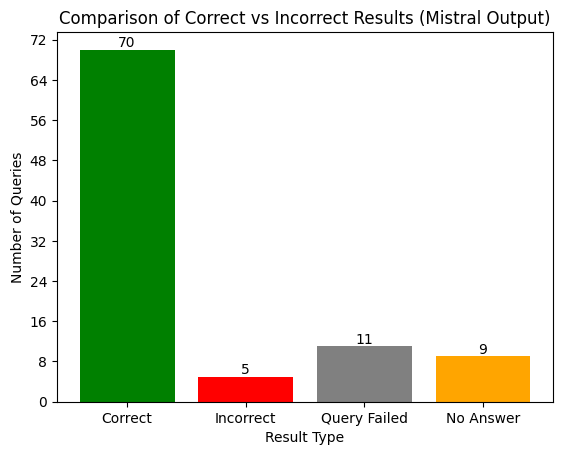

In [6]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
lama_output_file_path = "dbpedia_query_results_mistral.json"
previous_step_output_file_path = "mistral_wiki_trans_sparql_queries.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(lama_output_file_path, 'r') as f:
    lama_output_data = json.load(f)

with open(previous_step_output_file_path, 'r') as f:
    previous_step_data = json.load(f)

# Initialize comparison results
comparison_results = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['dbpedia_results'] for entry in solution_data}

# Compare answers
total_questions = len(lama_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0

for lama_entry in lama_output_data:
    question = lama_entry.get("natural_language_question")
    lama_answers = lama_entry.get("answers", [])

    # Count query failures and no answers
    if "Query failed" in lama_answers:
        query_failed_count += 1
        continue
    if "No answer" in lama_answers:
        no_answer_count += 1
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if all expected answers are in the LLM output and vice versa (ignoring order)
        is_correct = set(expected_answers) == set(lama_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "lama_answers": lama_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

# Save the results to an Excel file for review
output_excel_file = "comparison_results_mistral_dbpedia.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries: {incorrect_count}")
print(f"Query Failed: {query_failed_count}")
print(f"No Answer Queries: {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")

# Compare with previous step
previous_total_queries = len(previous_step_data)

# Ensure proper handling of missing keys
previous_successful_queries = sum(
    1 for result in previous_step_data 
    if "answers" in result and "No answer" not in result["answers"] and "Query failed" not in result["answers"]
)

previous_accuracy = (previous_successful_queries / previous_total_queries) * 100 if previous_total_queries > 0 else 0

print("\nComparison with previous step:")
print(f"Previous Step Total Queries: {previous_total_queries}")
print(f"Previous Step Successful Queries: {previous_successful_queries}")
print(f"Previous Step Accuracy: {previous_accuracy:.2f}%")

# Calculate accuracy improvement
accuracy_improvement = accuracy - previous_accuracy
print(f"Accuracy improvement from previous step: {accuracy_improvement:.2f}%")

# Visualize the current vs previous step comparison
categories = ['Correct', 'Incorrect', 'Query Failed', 'No Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['green', 'red', 'gray', 'orange']

fig, ax = plt.subplots()
bars = ax.bar(categories, counts, color=colors)

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

# Configure y-axis to show only integer values
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add title and labels
plt.title('Comparison of Correct vs Incorrect Results (Mistral Output)')
plt.xlabel('Result Type')
plt.ylabel('Number of Queries')
plt.show()
